## Bivariate Multi-Head LDA

In [313]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_theme()

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In the multi-head LDA, first a projection vector is learnt using both the target ($n$) and OOD ($m$) data. In our case, we consider target and OOD tasks are both binary classification tasks. Hence, there are four classes in total. Under these conditions, the projection vector is estimated according to the following expression:

$$ \omega = \argmax_{\omega} \frac{\omega^\top S_b \omega}{\omega^\top S_w \omega} $$

where, 

$$ S_b = \frac{1}{n+m} \sum_{i=1}^{n+m} (X_i - \bar{X}) (X_i - \bar{X})^\top $$
$$ S_w = \frac{n_1 S_{t1} + n_0 S_{t0} + m_1 S_{o1} + m_0 S_{o0}}{n+m} $$

Here, $S_{t1}, S_{t0}, S_{o1}, S_{o0}$ are sample covariance matrices of target class 1, target class 0, OOD class 1, and OOD class 0, repectively.

After the projection vector is estimated, the threshold $c_{in}$ is estimated by, 

$$ c_{in} = \frac{\omega^\top \bar{X}_{t0} + \omega^\top \bar{X}_{t1}}{2} $$

where $\bar{X}_{t0}, \bar{X}_{t1}$ are sample means of target class 0 and class 1 respectively.


In [325]:
# support functions
def generate_in_distribution_data(n, mu, pi_in):
    n_1 = int(n*pi_in)
    n_0 = int(n*(1-pi_in))
    mu_1 = np.array([mu, 0])
    mu_0 = -mu_1
    X_0 = np.random.multivariate_normal(mu_0, np.identity(2), n_0).T
    X_1 = np.random.multivariate_normal(mu_1, np.identity(2), n_1).T
    X = np.concatenate((X_0, X_1), axis=-1)
    Y = np.concatenate((np.zeros(n_0), np.ones(n_1)))
    return X, Y

def generate_out_distribution_data(n, mu, pi_in, theta):
    n_1 = int(n*pi_in)
    n_0 = int(n*(1-pi_in))
    mu_1 = np.array([mu, 0])
    mu_0 = -mu_1
    theta = np.radians(theta)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, s), (-s, c)))
    X_0 = np.random.multivariate_normal(np.matmul(R, mu_0.T).T, np.identity(2), n_0).T
    X_1 = np.random.multivariate_normal(np.matmul(R, mu_1.T).T, np.identity(2), n_1).T
    X = np.concatenate((X_0, X_1), axis=-1)
    Y = np.concatenate((np.zeros(n_0), np.ones(n_1)))
    return X, Y

def compute_decision_rule(X_in, Y_in, X_out, Y_out):
    N = len(Y_in) + len(Y_out)

    X = np.concatenate((X_in, X_out), axis=-1)
    X_bar = np.mean(X, axis=-1, keepdims=True)
    X_centered = X - X_bar
    S_b = np.matmul(X_centered, X_centered.T)/N

    X_in_0 = X_in[:, Y_in == 0]
    X_in_0_bar = np.mean(X_in_0, axis=-1, keepdims=True)
    X_centered = X_in_0 - X_in_0_bar
    S_w_in_0 = np.matmul(X_centered, X_centered.T)

    X_in_1 = X_in[:, Y_in == 1]
    X_in_1_bar = np.mean(X_in_1, axis=-1, keepdims=True)
    X_centered = X_in_1 - X_in_1_bar
    S_w_in_1 = np.matmul(X_centered, X_centered.T)

    X_out_0 = X_out[:, Y_out == 0]
    X_out_0_bar = np.mean(X_out_0, axis=-1, keepdims=True)
    X_centered = X_out_0 - X_out_0_bar
    S_w_out_0 = np.matmul(X_centered, X_centered.T)

    X_out_1 = X_out[:, Y_out == 1]
    X_out_1_bar = np.mean(X_out_1, axis=-1, keepdims=True)
    X_centered = X_out_1 - X_out_1_bar
    S_w_out_1 = np.matmul(X_centered, X_centered.T)

    S_w = (S_w_in_0 + S_w_in_1 + S_w_out_0 + S_w_out_1)/N

    # estimate projection vector
    e, v = np.linalg.eig(np.matmul(np.linalg.inv(S_w), S_b))
    omega = v[:, np.argmax(e)]
    
    # estimate threshold
    X_in_projected = np.matmul(omega.T, X_in)
    c_in = (np.mean(X_in_projected[Y_in == 0]) + np.mean(X_in_projected[Y_in == 1]))/2
    
    return omega, c_in

def compute_empirical_risk(X, Y, omega, c):
    Y_pred = (np.matmul(omega.T, X) > c).astype('int')
    risk = 1 - np.mean(Y_pred == Y)
    return risk

def visualize_projection_vector(n, m, theta, mu=3, pi_in=0.5, pi_out=0.5):
    X_in, Y_in = generate_in_distribution_data(n, mu, pi_in)
    X_out, Y_out = generate_out_distribution_data(m, mu, pi_out, theta)
    omega, c = compute_decision_rule(X_in, Y_in, X_out, Y_out)

    m = omega[1]/omega[0]
    x = np.arange(-5, 5, 0.1)
    y = m*x

    fig, ax = plt.subplots()
    ax.scatter(X_in[:, Y_in==0][0, :], X_in[:, Y_in==0][1, :], c='b')
    ax.scatter(X_in[:, Y_in==1][0, :], X_in[:, Y_in==1][1, :], c='b')
    ax.scatter(X_out[:, Y_out==0][0, :], X_out[:, Y_out==0][1, :], c='r')
    ax.scatter(X_out[:, Y_out==1][0, :], X_out[:, Y_out==1][1, :], c='r')
    ax.plot(x, y, 'k')
    ax.set_xlim([-5, 5])
    ax.set_ylim([-5, 5])

def run_simulation(
    n = 4,
    n_test = 500,
    mu = 3,
    pi_in = 0.5,
    pi_out = 0.5,
    Theta = [0, 10, 45, 90],
    m_sizes = np.arange(0, 21, 1),
    reps = 1000,
):
    X_test, y_test = generate_in_distribution_data(n_test, mu, pi_in)

    df = pd.DataFrame()
    
    i = 0
    for m in m_sizes:
        for r, rep in enumerate(range(reps)):
            df.at[i, "m"] = m
            df.at[i, "r"] = r
            X_in, Y_in = generate_in_distribution_data(n, mu, pi_in)
            
            for theta in Theta:
                X_out, Y_out = generate_out_distribution_data(m, mu, pi_out, theta)
                omega, c = compute_decision_rule(X_in, Y_in, X_out, Y_out)
                df.at[i, str(theta)] = compute_empirical_risk(X_test, y_test, omega, c)
            i+=1
    
    dfm = df.melt(['m', 'r'], var_name='Theta', value_name='Risk')
    fig, ax = plt.subplots(figsize=(10, 10), facecolor='white')
    ax = sns.lineplot(data=dfm, x="m", y="Risk", hue="Theta", ax=ax, markers=True, ci=95, lw=2)
    ax.set_ylabel("Expected Risk")
    ax.set_xlabel(r"$m/n, n={}$".format(n))
    # ax.set_xlim([0, 100])
    return df

### Visualize the Estimated Projection Vector

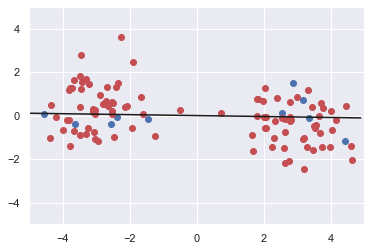

In [318]:
visualize_projection_vector(
    n=10,
    m=100,
    theta=10
)

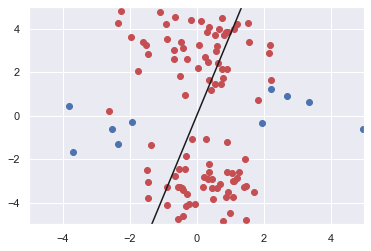

In [319]:
visualize_projection_vector(
    n=10,
    m=100,
    theta=90
)

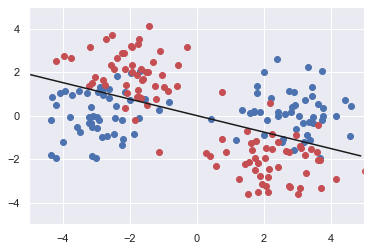

In [320]:
visualize_projection_vector(
    n=100,
    m=100,
    theta=45
)

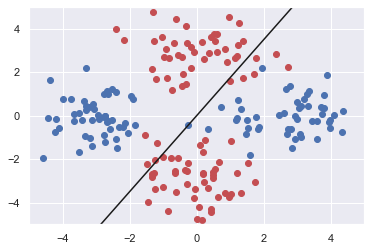

In [321]:
visualize_projection_vector(
    n=100,
    m=100,
    theta=90
)

### Simulations

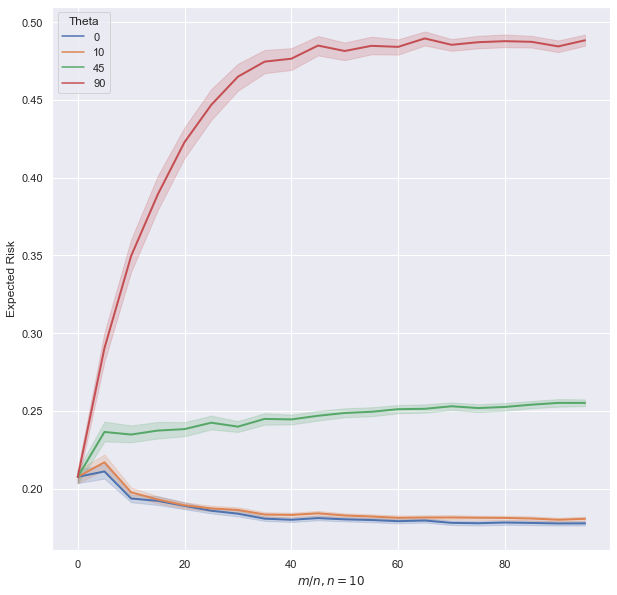

In [326]:
df = run_simulation(
    n = 10,
    n_test = 500,
    mu = 1,
    pi_in = 0.5,
    pi_out = 0.5,
    Theta = [0, 10, 45, 90],
    m_sizes = np.arange(0, 100, 5),
    reps = 1000,
)